In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
import llm_programs
from llm_programs import DocDir, DocTransform

importlib.reload(llm_programs)

from llm_programs import DocDir, DocTransform

from pathlib import Path

import matplotlib.pyplot as plt
import re

In [3]:
root = Path('../..')
parent = root / 'data/contracts/confidential/'
docdir = DocDir(parent / 'contracts_1_markerpdf')

total_n_pages = sum(1 for doc in docdir.docs() for page in doc.pages())
total_n_pages

6778

## Table char freqs (dash, pipe)

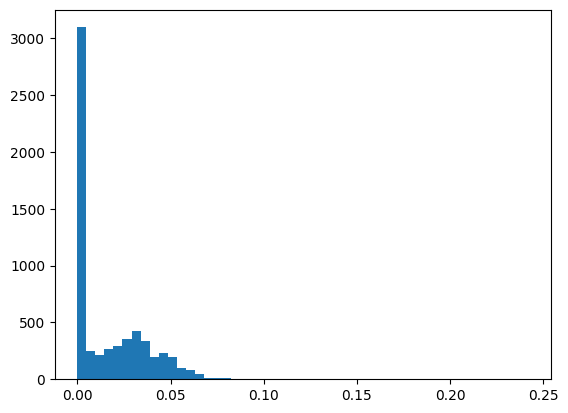

In [ ]:
dash_freq = {}
for doc in docdir.docs():
    for i, content in doc.pages(enum=True):
        dash_count = content.count('|')
        dash_freq[doc, i] = dash_count / len(content) if len(content) > 0 else 0

dash_freq_values = list(dash_freq.values())

# Create a histogram
plt.hist(dash_freq_values, bins=50)
plt.show()

In [ ]:
dash_freq_items = sorted(dash_freq.items(), key=lambda x: x[1], reverse=True)
x = 2000
print(*dash_freq_items[x:x+10], sep='\n')

In [27]:
len(dash_freq_items)

6125

In [ ]:
total_n_pages_filtered = sum(1 for doc in docdir.docs() for i, page in doc.pages(enum=True) if dash_freq[doc, i] > 0.03)
total_n_pages_filtered, round(total_n_pages_filtered / total_n_pages, 2)

(1572, 0.26)

## Cleaning Transform

In [4]:
# https://stackoverflow.com/a/79249574
MD_TABLE_REGEX = re.compile(r"((?:\| *[^|\r\n]+ *)+\|)(?:\r?\n)((?:\|[ :]?-+[ :]?)+\|)((?:(?:\r?\n)(?:\| *[^|\r\n]+ *)+\|)+)")

test_str = """
### Table 1: Fruit Information

| Fruit     | Color    | Taste  | Seasonal Availability |
|-----------|----------|--------|-----------------------|
| Apple     | Red      | Sweet  | Fall                  |
| Banana    | Yellow   | Sweet  | All Year              |
| Orange    | Orange   | Citrus | Winter                |
| Strawberry| Red      | Sweet  | Spring                |
| Grape     | Purple   | Sweet/Tart | Fall              |

### Table 2: Countries and Capitals

| Country    | Capital       | Population (millions) |
|------------|---------------|-----------------------|
| USA        | Washington D.C.| 331                   |
| Canada     | Ottawa        | 38                    |
| Germany    | Berlin        | 83                    |
| Japan      | Tokyo         | 126                   |
| Australia  | Canberra      | 25                    |

some text after
"""

re.sub(MD_TABLE_REGEX, "", test_str)


'\n### Table 1: Fruit Information\n\n\n\n### Table 2: Countries and Capitals\n\n\n\nsome text after\n'

In [5]:
path_clean = parent / 'contracts_2_clean_v5'

if not path_clean.exists():

    transform = DocTransform(docdir, path_clean)

    def clean_fn(content):
        new_content = re.sub(MD_TABLE_REGEX, "", content)
        new_content = new_content.replace('<br>', '')
        new_content = re.sub(r'^Image /page.*$', '', new_content, flags=re.MULTILINE)
        new_content = re.sub(r'\.{10,}', '', new_content)
        return new_content

    docdir_clean = transform.apply(clean_fn, debug=True)

else:
    docdir_clean = DocDir(path_clean)

In [6]:
docdir.get_total_n_pages(), docdir.get_total_n_chars()

(6778, 32785514)

In [7]:
docdir_clean.get_total_n_pages(), docdir_clean.get_total_n_chars()

(5078, 9811193)

In [8]:
docdir_clean.get_total_n_chars() / docdir.get_total_n_chars()

0.29925390219595155

## New page sizes - sanity check

In [ ]:
lengths = {}

for doc in docdir_clean.docs():
    for i, content in doc.pages(enum=True):
        lengths[doc, i] = len(content)

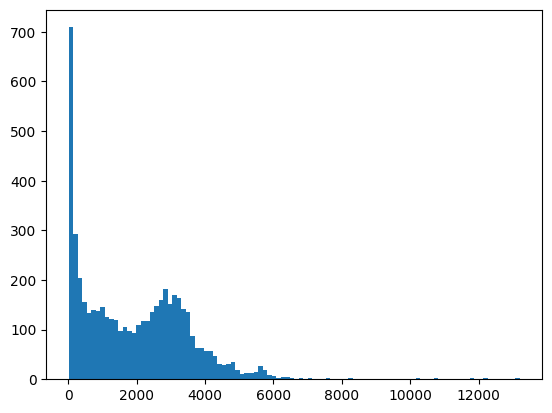

In [12]:
# Extract the lengths from the dictionary
length_values = list(lengths.values())

# Create a histogram
plt.hist(length_values, bins=100)
plt.show()

In [ ]:
longest_pair = max(lengths.items(), key=lambda x: x[1])
longest_pair

In [ ]:
for i, page in longest_pair[0][0].pages(enum=True):
    print(f"== Page {i} ==")
    print()
    print(page)
    print()
    print('---')
    print()